# 🩺 Breast Cancer Stage Prediction (SEER / AJCC 6th Edition — 3 Classes)

This notebook builds machine learning models to predict **AJCC 6th edition stage groups** for breast cancer using the SEER dataset:
**IIA, IIB, IIIA**.

The workflow is designed to be reproducible and to highlight both:
- **Overall predictive performance** (accuracy, weighted-F1)
- **Per-class sensitivity** (especially minimizing **false negatives** across the stage groups)

> Important note: Some staging-related variables (e.g., *T Stage*, *N Stage*, *A Stage*, or other direct staging encodings) can act as “shortcut” features and lead to overly optimistic results.  
> This notebook removes those variables to evaluate models using more general clinical/demographic predictors.

---

## Notebook Structure
1. Load & clean dataset  
2. Filter target to **3 classes** (IIA, IIB, IIIA) and encode labels  
3. Build feature set and remove leakage / shortcut staging variables  
4. Train/test split (stratified)  
5. Train baseline models (e.g., Logistic Regression, Random Forest)  
6. Evaluation: classification report + confusion matrix + per-class error analysis  


In [2]:
import pandas as pd

df = pd.read_csv("../data/data.csv")


target_stages = ['IIA', 'IIB', 'IIIA']
df_filtered = df[df['6th Stage'].isin(target_stages)].copy()

# Check the new distribution
print("New distribution of stages:")
print(df_filtered['6th Stage'].value_counts())
print(f"\nTotal rows remaining: {len(df_filtered)}")

New distribution of stages:
6th Stage
IIA     1305
IIB     1130
IIIA    1050
Name: count, dtype: int64

Total rows remaining: 3485


In [3]:

if 'Unnamed: 3' in df_filtered.columns:
    df_filtered = df_filtered.drop(columns=['Unnamed: 3'])

# Clean up column names 

df_filtered.columns = df_filtered.columns.str.strip()


print("Missing values in each column:")
print(df_filtered.isnull().sum())

df_filtered.head()

Missing values in each column:
Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64


,Age,Race,Marital Status,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive
2,67,White,Married (including common law),T2,N1,IIB,Poorly differentiated; Grade III,Regional,25,Positive,Positive,4,1,2,Dead
3,46,White,Divorced,T1,N1,IIA,Moderately differentiated; Grade II,Regional,19,Positive,Positive,26,1,2,Dead
4,63,White,Married (including common law),T2,N2,IIIA,Moderately differentiated; Grade II,Regional,35,Positive,Positive,21,5,3,Dead
6,64,White,Single (never married),T2,N1,IIB,Moderately differentiated; Grade II,Regional,22,Positive,Positive,1,1,3,Dead


In [4]:
from sklearn.preprocessing import LabelEncoder

# create a copy to keep original filtered data safe
df_encoded = df_filtered.copy()


df_encoded['Estrogen Status'] = df_encoded['Estrogen Status'].map({'Positive': 1, 'Negative': 0})
df_encoded['Progesterone Status'] = df_encoded['Progesterone Status'].map({'Positive': 1, 'Negative': 0})
df_encoded['Status'] = df_encoded['Status'].map({'Alive': 1, 'Dead': 0})
df_encoded['A Stage'] = df_encoded['A Stage'].map({'Regional': 1, 'Distant': 0})

# turns IIA, IIB, IIIA into 0, 1, 2
le = LabelEncoder()
df_encoded['6th Stage'] = le.fit_transform(df_encoded['6th Stage'])


df_encoded = pd.get_dummies(df_encoded, columns=['Race', 'Marital Status', 'T Stage', 'N Stage', 'Grade'])

print("Data encoded successfully. New shape:", df_encoded.shape)
df_encoded.head()

Data encoded successfully. New shape: (3485, 27)


,Age,6th Stage,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status,...,Marital Status_Widowed,T Stage_T1,T Stage_T2,T Stage_T3,N Stage_N1,N Stage_N2,Grade_Moderately differentiated; Grade II,Grade_Poorly differentiated; Grade III,Grade_Undifferentiated; anaplastic; Grade IV,Grade_Well differentiated; Grade I
1,47,2,1,45,1,1,25,9,2,1,...,False,False,True,False,False,True,True,False,False,False
2,67,1,1,25,1,1,4,1,2,0,...,False,False,True,False,True,False,False,True,False,False
3,46,0,1,19,1,1,26,1,2,0,...,False,True,False,False,True,False,True,False,False,False
4,63,2,1,35,1,1,21,5,3,0,...,False,False,True,False,False,True,True,False,False,False
6,64,1,1,22,1,1,1,1,3,0,...,False,False,True,False,True,False,True,False,False,False


In [5]:
# define feature set by excluding biased columns
X = df_encoded.drop(columns=['6th Stage', 'Status', 'Survival Months'])
# define target variable
y = df_encoded['6th Stage']

print("Features selected successfully.")
print(f"Number of columns being used as inputs: {X.shape[1]}")
print("Biased columns ('Status', 'Survival Months') have been excluded.")

Features selected successfully.
Number of columns being used as inputs: 24
Biased columns ('Status', 'Survival Months') have been excluded.


In [6]:
from sklearn.model_selection import train_test_split

#Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 2788
Testing samples: 697


In [7]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()


X_train_scaled = scaler.fit_transform(X_train)


X_test_scaled = scaler.transform(X_test)

print(" All features are now on the same scale.")

 All features are now on the same scale.


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize and Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict
y_pred = rf_model.predict(X_test_scaled)

# Print Stats
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\n--- Detailed Statistics ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))



Overall Accuracy: 100.00%

--- Detailed Statistics ---
              precision    recall  f1-score   support

         IIA       1.00      1.00      1.00       261
         IIB       1.00      1.00      1.00       226
        IIIA       1.00      1.00      1.00       210

    accuracy                           1.00       697
   macro avg       1.00      1.00      1.00       697
weighted avg       1.00      1.00      1.00       697



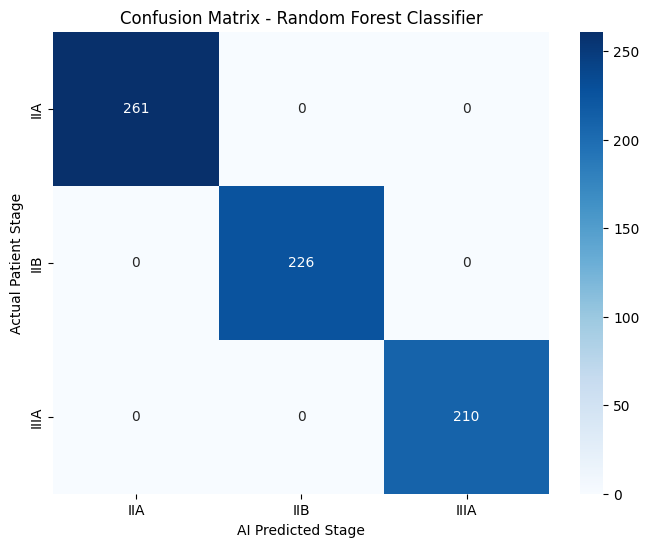

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)

plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('AI Predicted Stage')
plt.ylabel('Actual Patient Stage')
plt.show()



C:\Users\cowbo\AppData\Local\Temp\ipykernel_31516\755864407.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


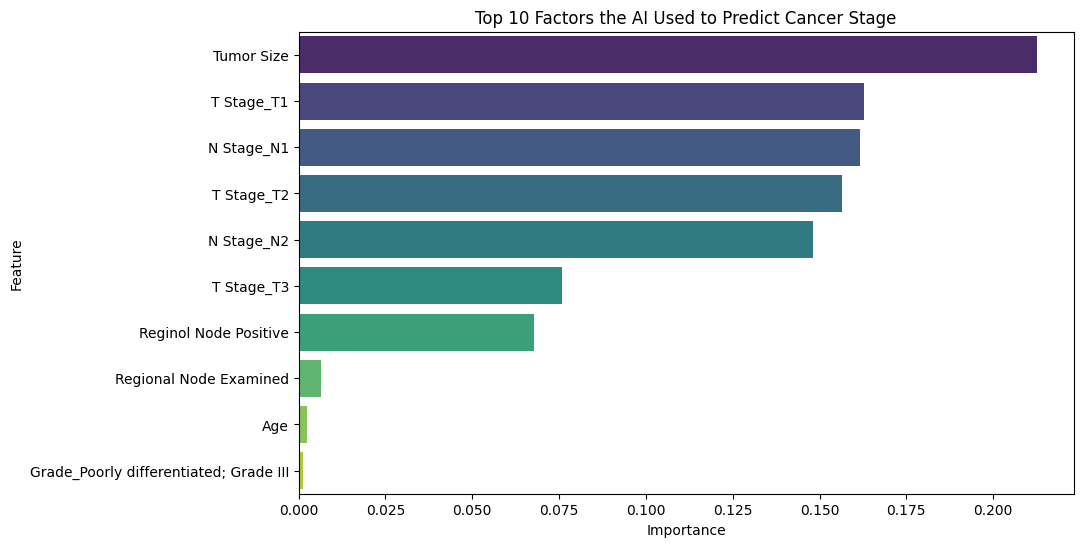

Top 5 most important features:
       Feature  Importance
2   Tumor Size    0.212548
15  T Stage_T1    0.162665
18  N Stage_N1    0.161553
16  T Stage_T2    0.156521
19  N Stage_N2    0.148254


In [10]:
import pandas as pd
import numpy as np

# Get the importance scores from the model
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 most influential factors
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Factors the AI Used to Predict Cancer Stage')
plt.show()

print("Top 5 most important features:")
print(feature_importance_df.head(5))

In [11]:
# Drop only A/T/N stage features 
cols_to_drop = (
    ['A Stage'] +
    [c for c in X.columns if c.startswith('T Stage_') or c.startswith('N Stage_')]
)

# Hard-mode train/test without stage indicators
X_train_hard = pd.DataFrame(X_train_scaled, columns=X.columns).drop(columns=cols_to_drop, errors="ignore")
X_test_hard  = pd.DataFrame(X_test_scaled,  columns=X.columns).drop(columns=cols_to_drop, errors="ignore")

print(f"Removed {len(cols_to_drop)} stage-indicator columns.")
print(f"Remaining features: {X_train_hard.shape[1]}")


Removed 6 stage-indicator columns.
Remaining features: 18


Accuracy: 0.8824


e:\Masters\Data Exploration\Breast Cancer Identifier\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


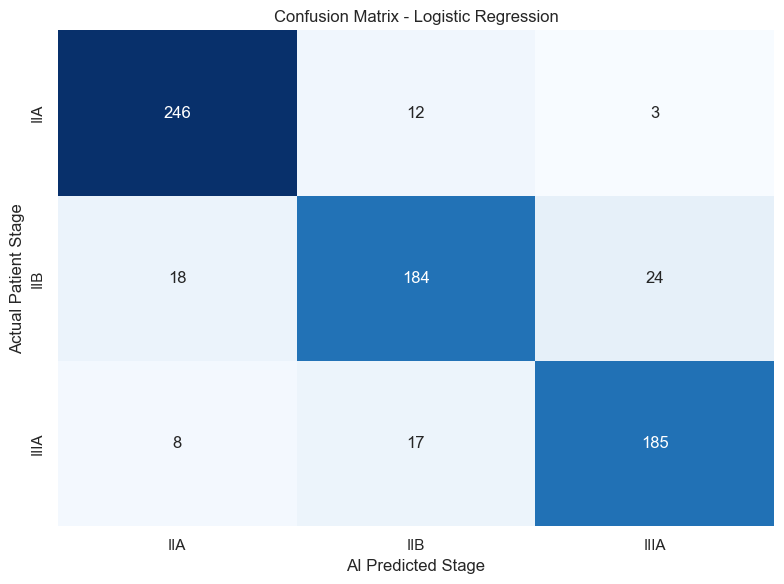

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Logistic Regression
lr = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    multi_class="multinomial",
    random_state=42
)

lr.fit(X_train_hard, y_train)

# Predictions
y_pred = lr.predict(X_test_hard)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Reset to clean white background
sns.set_theme(style="white")

plt.figure(figsize=(8, 6), facecolor="white")
ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",          
    cbar=False,           
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

ax.set_facecolor("white")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("AI Predicted Stage")
plt.ylabel("Actual Patient Stage")
plt.tight_layout()
plt.show()




Random Forest Accuracy: 0.9727


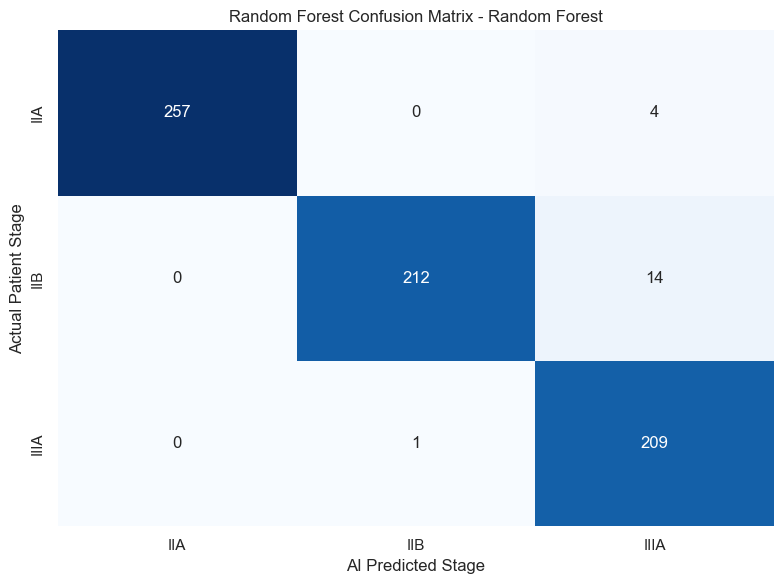

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train_hard, y_train)

# Predictions
y_pred_rf = rf.predict(X_test_hard)

# Accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)


sns.set_theme(style="white")
plt.figure(figsize=(8, 6), facecolor="white")

ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

ax.set_facecolor("white")
plt.title("Random Forest Confusion Matrix - Random Forest")
plt.xlabel("AI Predicted Stage")
plt.ylabel("Actual Patient Stage")
plt.tight_layout()
plt.show()




Top 30 Feature Importances (Random Forest):
                                                       feature  importance
                                                    Tumor Size    0.545920
                                         Reginol Node Positive    0.348132
                                        Regional Node Examined    0.038386
                                                           Age    0.031177
                        Grade_Poorly differentiated; Grade III    0.003991
                                           Progesterone Status    0.003882
                 Marital Status_Married (including common law)    0.003495
                            Grade_Well differentiated; Grade I    0.003218
                                                    Race_White    0.002943
                                       Marital Status_Divorced    0.002763
                     Grade_Moderately differentiated; Grade II    0.002736
                         Marital Status_Single (never ma

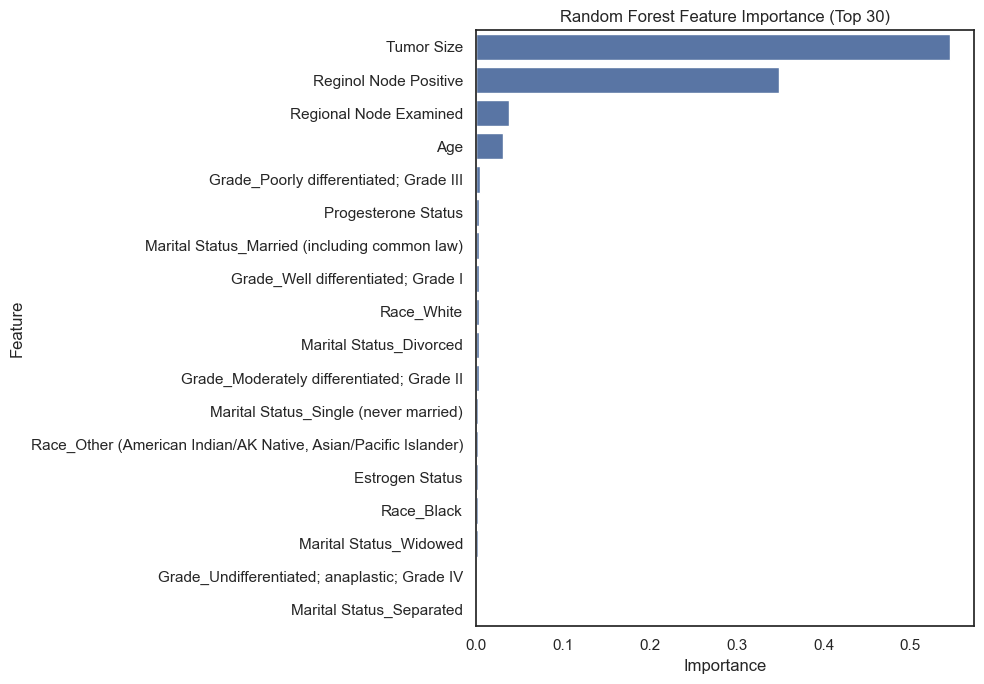

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make a sorted importance table
importances = rf.feature_importances_
feat_names = X_train_hard.columns

fi = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("Top 30 Feature Importances (Random Forest):")
print(fi.head(30).to_string(index=False))

top_n = 30
sns.set_theme(style="white")
plt.figure(figsize=(10, 7), facecolor="white")

ax = sns.barplot(
    data=fi.head(top_n),
    x="importance",
    y="feature",
    orient="h"
)

ax.set_facecolor("white")
plt.title(f"Random Forest Feature Importance (Top {top_n})")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Random Forest + SMOTE Accuracy: 0.9713


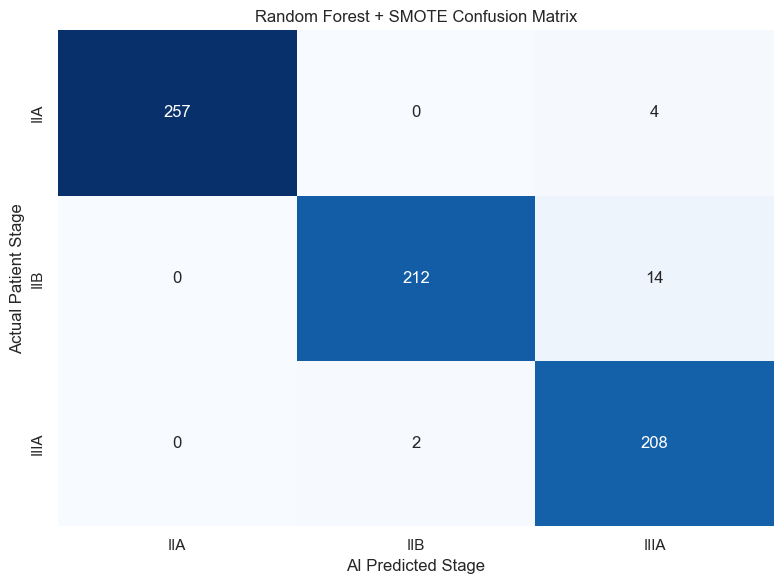

In [15]:
# SMOTE + Random Forest (apply SMOTE ONLY on training set)

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# SMOTE on training data only
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_sm, y_train_sm = smote.fit_resample(X_train_hard, y_train)

# Train Random Forest on SMOTEd data
rf_smote = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf_smote.fit(X_train_sm, y_train_sm)

# Predict on untouched test set
y_pred_rf_smote = rf_smote.predict(X_test_hard)

# Accuracy
acc = accuracy_score(y_test, y_pred_rf_smote)
print(f"Random Forest + SMOTE Accuracy: {acc:.4f}")

# Confusion matrix 
cm = confusion_matrix(y_test, y_pred_rf_smote)

sns.set_theme(style="white")
plt.figure(figsize=(8, 6), facecolor="white")
ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
ax.set_facecolor("white")
plt.title("Random Forest + SMOTE Confusion Matrix")
plt.xlabel("AI Predicted Stage")
plt.ylabel("Actual Patient Stage")
plt.tight_layout()
plt.show()
